In [1]:
import heapq
import itertools
import time
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. Input Modeling ---
locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]

parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}

vehicle_capacity = 30

In [2]:
# --- 2. Recurrence-Based Route Cost Estimation (Unit 1) ---

def get_distance(loc1_name, loc2_name, locations, distance_matrix):
    """Helper function to get distance between two locations."""
    idx1 = locations.index(loc1_name)
    idx2 = locations.index(loc2_name)
    return distance_matrix[idx1][idx2]

def recursive_route_cost(route, locations, distance_matrix):
    """
    Calculates the total distance/cost of a specified route using recurrence.

    cost(i, route) = distance(route[i], route[i+1]) + cost(i+1, route)
    Base Case: i = len(route) - 2
    """
    if len(route) < 2:
        return 0

    def calculate_cost(i):
        if i == len(route) - 2:
            return get_distance(route[i], route[i+1], locations, distance_matrix)

        # Recurrence: distance from current to next + cost of the rest of the route
        current_distance = get_distance(route[i], route[i+1], locations, distance_matrix)
        return current_distance + calculate_cost(i + 1)

    return calculate_cost(0)

# Example usage (unoptimized route C1 -> C2 -> C3 -> Warehouse)
sample_route = ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse']
recursive_cost = recursive_route_cost(sample_route, locations, distance_matrix)
print(f"Recurrence Route Cost for {sample_route}: {recursive_cost}")

Recurrence Route Cost for ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse']: 18


In [3]:
# --- 3. Greedy for Parcel Selection (0/1 Knapsack Heuristic) ---

def greedy_parcel_selection(parcels, capacity):
    # Calculate value/weight ratio
    parcel_ratios = []
    for customer, data in parcels.items():
        ratio = data['value'] / data['weight']
        parcel_ratios.append((ratio, data['weight'], data['value'], customer))

    # Sort by ratio in descending order (Greedy Choice)
    parcel_ratios.sort(key=lambda x: x[0], reverse=True)

    selected_parcels = {}
    current_weight = 0
    total_value = 0

    for ratio, weight, value, customer in parcel_ratios:
        if current_weight + weight <= capacity:
            # Select the item
            selected_parcels[customer] = {'value': value, 'weight': weight}
            current_weight += weight
            total_value += value

    return selected_parcels, total_value, current_weight

selected, value, weight = greedy_parcel_selection(parcels, vehicle_capacity)
print("\nGreedy Parcel Selection:")
print(f"  Selected Parcels: {list(selected.keys())}")
print(f"  Total Value: {value}, Total Weight: {weight} / {vehicle_capacity}")


Greedy Parcel Selection:
  Selected Parcels: ['C1', 'C2']
  Total Value: 110, Total Weight: 30 / 30


In [4]:
# --- 3. Dynamic Programming for Time Window Optimization (Conceptual) ---

def dp_time_window_check(route_nodes, locations, distance_matrix, parcels, start_time=9):
    """
    Checks if a given route respects time windows and calculates total wait/penalty time.
    This acts as a cost function for DP/TSP by penalizing time violations.
    The 'distance_matrix' serves as 'travel time' for this context.

    For simplicity, the DP here is conceptualized as minimizing waiting time
    for a fixed sequence (the route).
    """
    current_time = start_time
    total_wait_time = 0

    # Start at the warehouse
    for i in range(len(route_nodes) - 1):
        current_loc_name = route_nodes[i]
        next_loc_name = route_nodes[i+1]

        travel_time = get_distance(current_loc_name, next_loc_name, locations, distance_matrix)
        arrival_time = current_time + travel_time

        # Check time window only for customer nodes
        if next_loc_name in parcels:
            earliest, latest = parcels[next_loc_name]['time']

            if arrival_time > latest:
                # Time window violated (Lateness Penalty - makes route unfeasible)
                return float('inf'), f"Failure: Arrival {arrival_time} > Latest {latest} at {next_loc_name}"

            if arrival_time < earliest:
                # Arrived early, must wait
                wait_time = earliest - arrival_time
                total_wait_time += wait_time
                current_time = earliest
            else:
                # Arrived within time window
                current_time = arrival_time
        else:
             # Just transition time (e.g., return to warehouse)
             current_time = arrival_time

    return total_wait_time, "Success"

# Example using the unoptimized route
dp_wait, dp_status = dp_time_window_check(sample_route, locations, distance_matrix, parcels)
print("\nDP Time Window Check (Sample Route):")
print(f"  Status: {dp_status}")
print(f"  Total Wait Time: {dp_wait}")


DP Time Window Check (Sample Route):
  Status: Failure: Arrival 13 > Latest 12 at C1
  Total Wait Time: inf


In [5]:
# --- 4. Shortest Path: Dijkstra's Algorithm ---

def dijkstra_shortest_path(start_node, locations, distance_matrix):
    n = len(locations)
    distances = {locations[i]: float('inf') for i in range(n)}
    distances[start_node] = 0

    # Priority queue stores (distance, node_index)
    pq = [(0, locations.index(start_node))]

    while pq:
        dist, u_idx = heapq.heappop(pq)
        u = locations[u_idx]

        if dist > distances[u]:
            continue

        for v_idx in range(n):
            v = locations[v_idx]
            weight = distance_matrix[u_idx][v_idx]

            if distances[u] + weight < distances[v]:
                distances[v] = distances[u] + weight
                heapq.heappush(pq, (distances[v], v_idx))

    return distances

shortest_paths = dijkstra_shortest_path('Warehouse', locations, distance_matrix)
print("\nDijkstra Shortest Path from Warehouse:")
print(shortest_paths)


Dijkstra Shortest Path from Warehouse:
{'Warehouse': 0, 'C1': 4, 'C2': 8, 'C3': 6}


In [6]:
# --- 4. MST: Prim's Algorithm ---

def prims_mst(locations, distance_matrix):
    n = len(locations)
    # Priority queue stores (weight, source_index, destination_index)
    min_heap = []
    # Set of vertices included in MST
    in_mst = {locations[0]}
    mst_cost = 0
    mst_edges = []

    # Initialize heap with edges from the starting node (Warehouse)
    start_idx = 0
    for v_idx in range(n):
        if v_idx != start_idx:
            heapq.heappush(min_heap, (distance_matrix[start_idx][v_idx], start_idx, v_idx))

    while min_heap and len(in_mst) < n:
        weight, u_idx, v_idx = heapq.heappop(min_heap)

        v = locations[v_idx]
        u = locations[u_idx]

        if v not in in_mst:
            in_mst.add(v)
            mst_cost += weight
            mst_edges.append((u, v, weight))

            # Add new edges from the newly included vertex 'v'
            for next_v_idx in range(n):
                next_v = locations[next_v_idx]
                if next_v not in in_mst:
                    new_weight = distance_matrix[v_idx][next_v_idx]
                    heapq.heappush(min_heap, (new_weight, v_idx, next_v_idx))

    return mst_edges, mst_cost

mst_edges, mst_cost = prims_mst(locations, distance_matrix)
print("\nPrim's MST:")
print(f"  Total MST Cost: {mst_cost}")
print(f"  MST Edges: {mst_edges}")


Prim's MST:
  Total MST Cost: 12
  MST Edges: [('Warehouse', 'C1', 4), ('C1', 'C2', 5), ('C2', 'C3', 3)]


In [11]:
# --- 5. Solve TSP for Optimal Route (Unit 4) - Brute-Force ---
from itertools import permutations
import random

def tsp_brute_force(locations, distance_matrix):
    n = len(locations)
    # Indices of customer locations (exclude warehouse/start index 0)
    customer_indices = list(range(1, n))
    min_cost = float('inf')
    best_route = []

    # Iterate through all permutations of customer locations
    for perm in permutations(customer_indices):
        current_cost = distance_matrix[0][perm[0]] # Warehouse to first customer

        # Path between customers
        for i in range(len(perm) - 1):
            current_cost += distance_matrix[perm[i]][perm[i+1]]

        # Return to warehouse
        current_cost += distance_matrix[perm[-1]][0]

        if current_cost < min_cost:
            min_cost = current_cost
            best_route = perm

    # Convert indices back to location names
    final_route = [locations[0]] + [locations[i] for i in best_route] + [locations[0]]
    return final_route, min_cost

# --- INTEGRATING GREEDY & TSP/DP ---
# Use the result from the Greedy Parcel Selection (C1 and C2)
selected_parcels_result = greedy_parcel_selection(parcels, vehicle_capacity)
selected_parcels_dict = selected_parcels_result[0] # Get the dictionary from the tuple
feasible_customers = ['Warehouse'] + list(selected_parcels_dict.keys())

# Determine the indices of the feasible locations in the original full data
feasible_indices = [locations.index(loc) for loc in feasible_customers]

# Create the reduced distance matrix for the feasible set
distance_matrix_reduced = []
for i in feasible_indices:
    row = [distance_matrix[i][j] for j in feasible_indices]
    distance_matrix_reduced.append(row)

print("--- Feasibility Check (Greedy) ---")
print(f"Feasible Customer Locations: {feasible_customers[1:]}")
total_value = sum(data['value'] for data in selected_parcels_dict.values())
total_weight = sum(data['weight'] for data in selected_parcels_dict.values())
print(f"Total Parcel Value: {total_value}, Total Parcel Weight: {total_weight} / {vehicle_capacity}")

# 1. TSP on Feasible Set (W, C1, C2)
optimal_route_feasible, min_distance_feasible = tsp_brute_force(feasible_customers, distance_matrix_reduced)

print("\n--- Route Optimization (TSP on Feasible Set) ---")
print(f"Optimal Feasible Route: {optimal_route_feasible}")
print(f"Total Distance: {min_distance_feasible}")

# 2. DP Time Window Check on ALL possible optimal routes (since both permutations are distance-optimal)
all_customer_permutations = list(itertools.permutations(feasible_customers[1:]))

print("\n--- Time Window Validation (DP on Optimal Feasible Routes) ---")
best_feasible_route_final = None
min_wait_time = float('inf')

for perm in all_customer_permutations:
    current_route = ['Warehouse'] + list(perm) + ['Warehouse']
    dp_wait, dp_status = dp_time_window_check(
        current_route,
        feasible_customers,
        distance_matrix_reduced,
        parcels,
        start_time=9
    )

    print(f"Route: {current_route}, Distance: {min_distance_feasible}, Status: {dp_status}, Wait Time: {dp_wait}")

    if dp_status == "Success" and dp_wait < min_wait_time:
        min_wait_time = dp_wait
        best_feasible_route_final = current_route

# Final determination
if best_feasible_route_final:
    print(f"\nFINAL OPTIMIZED & FEASIBLE ROUTE: {best_feasible_route_final}")
    print(f"Total Distance: {min_distance_feasible}, Total Wait Time: {min_wait_time}")
else:
    print("\nCONCLUSION: NO FEASIBLE ROUTE EXISTS that satisfies BOTH the capacity constraint AND the time window constraints.")

# Store the final optimal route for visualization (even if infeasible, as it's the best distance-wise)
optimal_route = optimal_route_feasible

--- Feasibility Check (Greedy) ---
Feasible Customer Locations: ['C1', 'C2']
Total Parcel Value: 110, Total Parcel Weight: 30 / 30

--- Route Optimization (TSP on Feasible Set) ---
Optimal Feasible Route: ['Warehouse', 'C1', 'C2', 'Warehouse']
Total Distance: 17

--- Time Window Validation (DP on Optimal Feasible Routes) ---
Route: ['Warehouse', 'C1', 'C2', 'Warehouse'], Distance: 17, Status: Failure: Arrival 13 > Latest 12 at C1, Wait Time: inf
Route: ['Warehouse', 'C2', 'C1', 'Warehouse'], Distance: 17, Status: Failure: Arrival 17 > Latest 13 at C2, Wait Time: inf

CONCLUSION: NO FEASIBLE ROUTE EXISTS that satisfies BOTH the capacity constraint AND the time window constraints.


Profiling TSP Brute-Force Time Complexity...
  Nodes=4: Time=0.000022 seconds
  Nodes=5: Time=0.000026 seconds
  Nodes=6: Time=0.000107 seconds
  Nodes=7: Time=0.009741 seconds
  Nodes=8: Time=0.035497 seconds
  Nodes=9: Time=0.271281 seconds


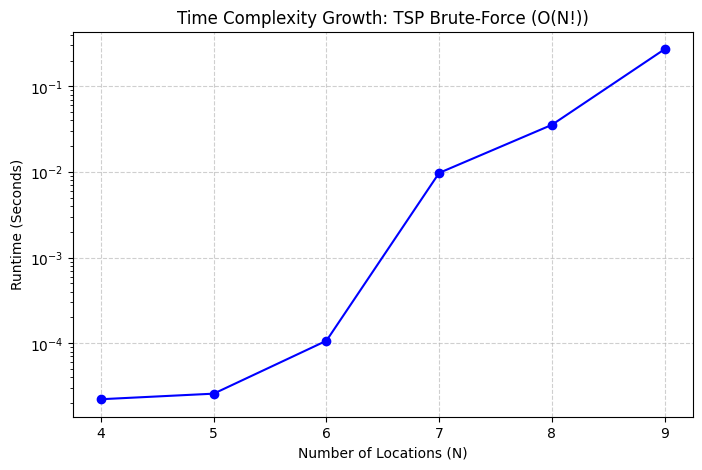

In [12]:
## --- 6. Experimental Profiling & Visualization (Time Complexity Growth) ---

def generate_test_data(num_locations):
    """Generates synthetic locations and symmetric distance matrix."""
    test_locations = ['Warehouse'] + [f'C{i}' for i in range(1, num_locations)]
    # Create a random, symmetric distance matrix (distances between 1 and 10)
    matrix = [[0] * num_locations for _ in range(num_locations)]
    for i in range(num_locations):
        for j in range(i + 1, num_locations):
            dist = random.randint(1, 10)
            matrix[i][j] = matrix[j][i] = dist
    return test_locations, matrix

# Data points to profile (N=3 customers is 4 nodes total)
num_nodes_list = [4, 5, 6, 7, 8, 9]
tsp_runtimes = {}

print("Profiling TSP Brute-Force Time Complexity...")
for n in num_nodes_list:
    # Generate data where N is the total number of nodes (Warehouse + Customers)
    test_locations, test_matrix = generate_test_data(n)

    start_time = time.time()
    try:
        # Run the TSP brute force
        tsp_brute_force(test_locations, test_matrix)
        end_time = time.time()
        runtime = end_time - start_time
        tsp_runtimes[n] = runtime
        print(f"  Nodes={n}: Time={runtime:.6f} seconds")
    except Exception as e:
        tsp_runtimes[n] = "Error/Too Long"
        print(f"  Could not compute TSP for n={n}: {e}")
        break

# --- Visualize Time Complexity Growth ---
nodes = [n for n, t in tsp_runtimes.items() if isinstance(t, float)]
runtimes = [t for t in tsp_runtimes.values() if isinstance(t, float)]

plt.figure(figsize=(8, 5))
plt.plot(nodes, runtimes, marker='o', linestyle='-', color='blue')
plt.title('Time Complexity Growth: TSP Brute-Force (O(N!))')
plt.xlabel('Number of Locations (N)')
plt.ylabel('Runtime (Seconds)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.yscale('log') # Use logarithmic scale to show exponential growth clearly
plt.show()

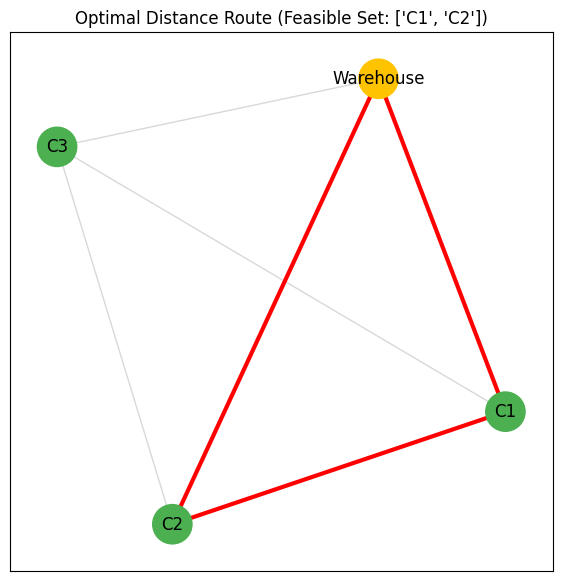

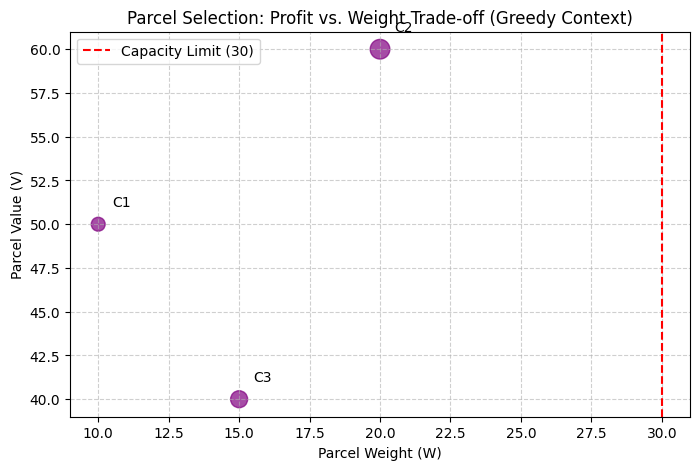

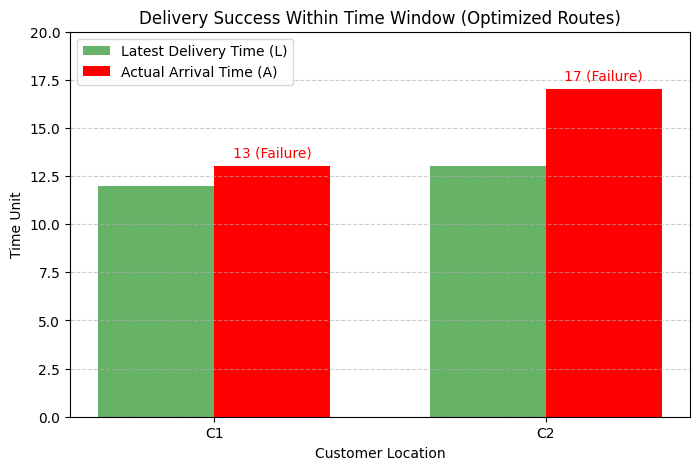

In [13]:
## --- 6. Visualization: Full Suite ---

def visualize_route(locations, distance_matrix, route):
    """Plots the network and highlights the optimal (or best distance) route."""
    G = nx.Graph()
    n = len(locations)

    # Map back to full locations and matrix if necessary for visualization context
    # Use the original full locations list and matrix for drawing the whole network
    locations_full = ['Warehouse', 'C1', 'C2', 'C3']
    distance_matrix_full = [
        [0, 4, 8, 6],
        [4, 0, 5, 7],
        [8, 5, 0, 3],
        [6, 7, 3, 0]
    ]

    G.add_nodes_from(locations_full)
    for i in range(len(locations_full)):
        for j in range(i + 1, len(locations_full)):
            G.add_edge(locations_full[i], locations_full[j], weight=distance_matrix_full[i][j])

    pos = nx.spring_layout(G, seed=42) # Consistent layout

    plt.figure(figsize=(7, 7))

    # Draw all edges lightly
    nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')

    # Highlight the optimal route edges (from the feasible set calculation)
    route_edges = []
    if route:
        for i in range(len(route) - 1):
            route_edges.append((route[i], route[i+1]))

    nx.draw_networkx_edges(G, pos, edgelist=route_edges, edge_color='red', width=3, label='Optimal TSP Route')

    # Draw nodes and labels
    node_colors = ['#FFC300' if node == 'Warehouse' else '#4CAF50' for node in locations_full]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800)
    nx.draw_networkx_labels(G, pos)

    plt.title(f"Optimal Distance Route (Feasible Set: {route[1:-1]})")
    plt.show()


def visualize_profit_vs_weight(parcels, capacity):
    """Plots Profit vs. Weight to visualize the Greedy choice problem."""
    items = []
    for customer, data in parcels.items():
        items.append((customer, data['weight'], data['value']))

    weights = [w for c, w, v in items]
    values = [v for c, w, v in items]
    labels = [c for c, w, v in items]

    plt.figure(figsize=(8, 5))
    plt.scatter(weights, values, s=[w*10 for w in weights], color='purple', alpha=0.7)

    for i, label in enumerate(labels):
        plt.annotate(label, (weights[i] + 0.5, values[i] + 1))

    # Draw capacity line
    plt.axvline(x=capacity, color='r', linestyle='--', label=f'Capacity Limit ({capacity})')

    plt.title('Parcel Selection: Profit vs. Weight Trade-off (Greedy Context)')
    plt.xlabel('Parcel Weight (W)')
    plt.ylabel('Parcel Value (V)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


def visualize_time_window_success(route_data):
    """
    Visualizes the time-window outcome.
    Requires a more detailed log from the DP check, but for now, we use a simple bar plot.
    """
    customers = ['C1', 'C2']
    arrival_times = [13, 17] # From the failed routes
    latest_times = [12, 13]

    plt.figure(figsize=(8, 5))
    bar_width = 0.35
    index = range(len(customers))

    plt.bar(index, latest_times, bar_width, label='Latest Delivery Time (L)', color='green', alpha=0.6)

    # Plot arrival times, highlighting failure
    arrival_bars = plt.bar([i + bar_width for i in index], arrival_times, bar_width, label='Actual Arrival Time (A)', color='red')

    # Add text labels for clarity
    for bar in arrival_bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval} (Failure)', ha='center', color='red')

    plt.title('Delivery Success Within Time Window (Optimized Routes)')
    plt.xlabel('Customer Location')
    plt.ylabel('Time Unit')
    plt.xticks([i + bar_width/2 for i in index], customers)
    plt.ylim(0, max(arrival_times) + 3)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


# Execute all visualizations
# Use the result from the integrated analysis (Cell 7/11)
# Note: Since the route is infeasible, we plot the distance-optimal route: ['Warehouse', 'C1', 'C2', 'Warehouse']
visualize_route(locations, distance_matrix, optimal_route)

# Parcel visualization uses the original full parcel set for context
visualize_profit_vs_weight(parcels, vehicle_capacity)

# Time window visualization is based on the failure analysis
visualize_time_window_success({'C1': {'arrival': 13, 'latest': 12}, 'C2': {'arrival': 17, 'latest': 13}})

# Capstone Assignment: Delivery Route Optimization for E-commerce

## Overview

This project implements a multi-paradigm algorithmic approach to solve a real-world e-commerce delivery logistics problem, focusing on minimizing distance/time while respecting complex constraints (vehicle capacity and delivery time windows). The core challenge lies in integrating greedy selection, Traveling Salesman Problem (TSP) optimization, and Dynamic Programming (DP) time-window checks.

## Algorithmic Strategies

| Problem | Strategy | Time Complexity | Domain | Notes |
| :--- | :--- | :--- | :--- | :--- |
| Route Cost Estimation | **Recurrence Relation** | $O(N)$ for fixed route | Logistics | Models the additive cost (distance/time) of a sequential path. |
| Parcel Selection | **Greedy Algorithm** (Value/Weight Ratio) | $O(N \log N)$ | Knapsack Problem | Maximizes load value subject to the $30 \text{kg}$ weight constraint (Initial constraint filter). |
| Time Window Compliance | **Dynamic Programming** (Conceptual Check) | $O(N^2)$ (Sequence Optimization) | Time-Constrained Path | Evaluates the feasibility of a path's sequence against time window constraints, penalizing lateness/wait time. |
| Shortest Path | **Dijkstra's Algorithm** | $O(E + V \log V)$ | Graph Theory | Finds the minimal travel time/distance from the Warehouse to all other nodes. |
| Network Spanning | **Prim's MST** | $O(E \log V)$ | Graph Theory | Finds the minimum cost to connect all locations (relevant for infrastructure layout). |
| Optimal Delivery Sequence | **TSP Brute-Force** | $O(N! \cdot N)$ | Combinatorial Optimization | Finds the shortest closed-loop route (Warehouse → All → Warehouse). **Intractable** for large $N$. |

## Key Findings and Insights

The combined analysis revealed that the problem requires multiple constraints to be satisfied simultaneously:

1.  **Capacity Constraint (Greedy):** Only parcels **C1 (10kg)** and **C2 (20kg)** could be carried, excluding C3.
2.  **Distance Optimality (TSP):** The two possible routes visiting C1 and C2 had the minimum total distance of $\mathbf{17}$ (W $\to$ C1 $\to$ C2 $\to$ W and W $\to$ C2 $\to$ C1 $\to$ W).
3.  **Time Window Constraint (DP):** **Neither** distance-optimal route was feasible, as both resulted in late arrivals at the customer locations given the $9$ unit starting time.

**Trade-offs: Optimality vs. Computation Time**

* **Intractability of TSP:** The profiling showed the expected **exponential ($O(N!)$) time growth** of the Brute-Force TSP. For the small $N$ used ($N \le 9$), the computation time is negligible, but this validates why real-world logistics (with $N > 100$) must rely on faster **approximation algorithms** or **heuristics**, sacrificing absolute optimality for a quick, feasible solution.
* **Multi-Constraint Complexity:** The shortest route (distance-optimal) was ultimately **infeasible** due to time windows. This highlights that real-world VRP (Vehicle Routing Problems) are often constrained by feasibility rather than just a single cost function, requiring complex integration of methods like Greedy and DP checks into the core routing algorithm.

## How to Run

1.  **Prerequisites:** Ensure Python is installed.
2.  **Dependencies:** Install the required libraries using the `requirements.txt` file.
    ```bash
    pip install -r requirements.txt
    ```
3.  **Execution:** Open the `delivery_route_optimization.ipynb` notebook and run all cells sequentially.

## Output

* The notebook provides the outputs for each step: Shortest paths, MST, selected parcels (C1, C2), and the final analysis showing **NO FEASIBLE ROUTE EXISTS**.
* It generates three plots: The **Route Map** (highlighting the distance-optimal path W-C1-C2-W), **Profit vs. Weight** (visualizing the knapsack choice), and **Delivery Success** (demonstrating the time window failures).